In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
string.digits,string.ascii_uppercase,string.ascii_lowercase

('0123456789', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz')

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


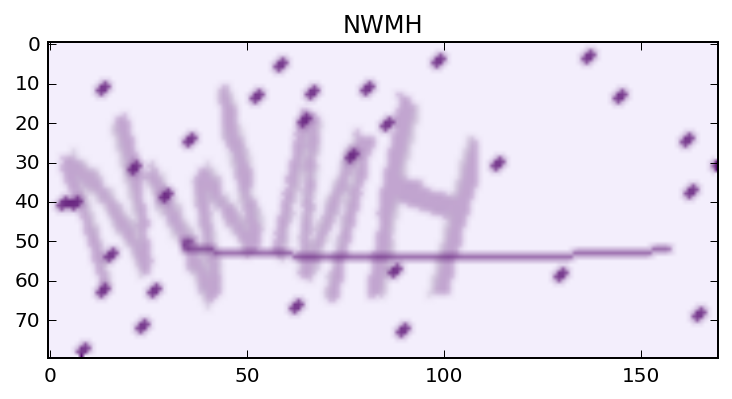

In [3]:
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

In [4]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

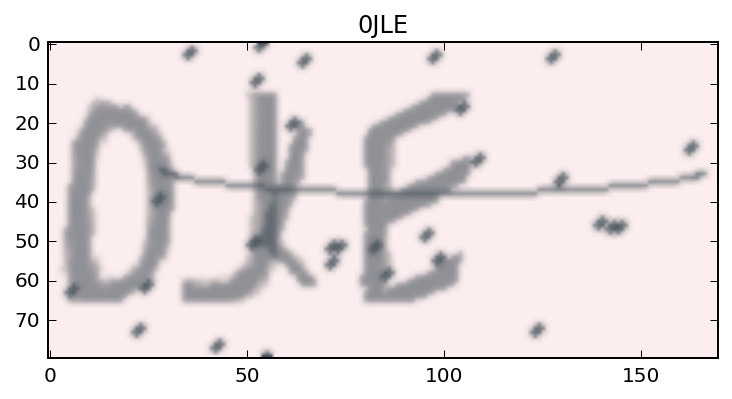

In [5]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(10))
plt.imshow(X[0])
plt.title(decode(y))

# 构建深度卷积神经网络

In [6]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(input=input_tensor, output=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="re

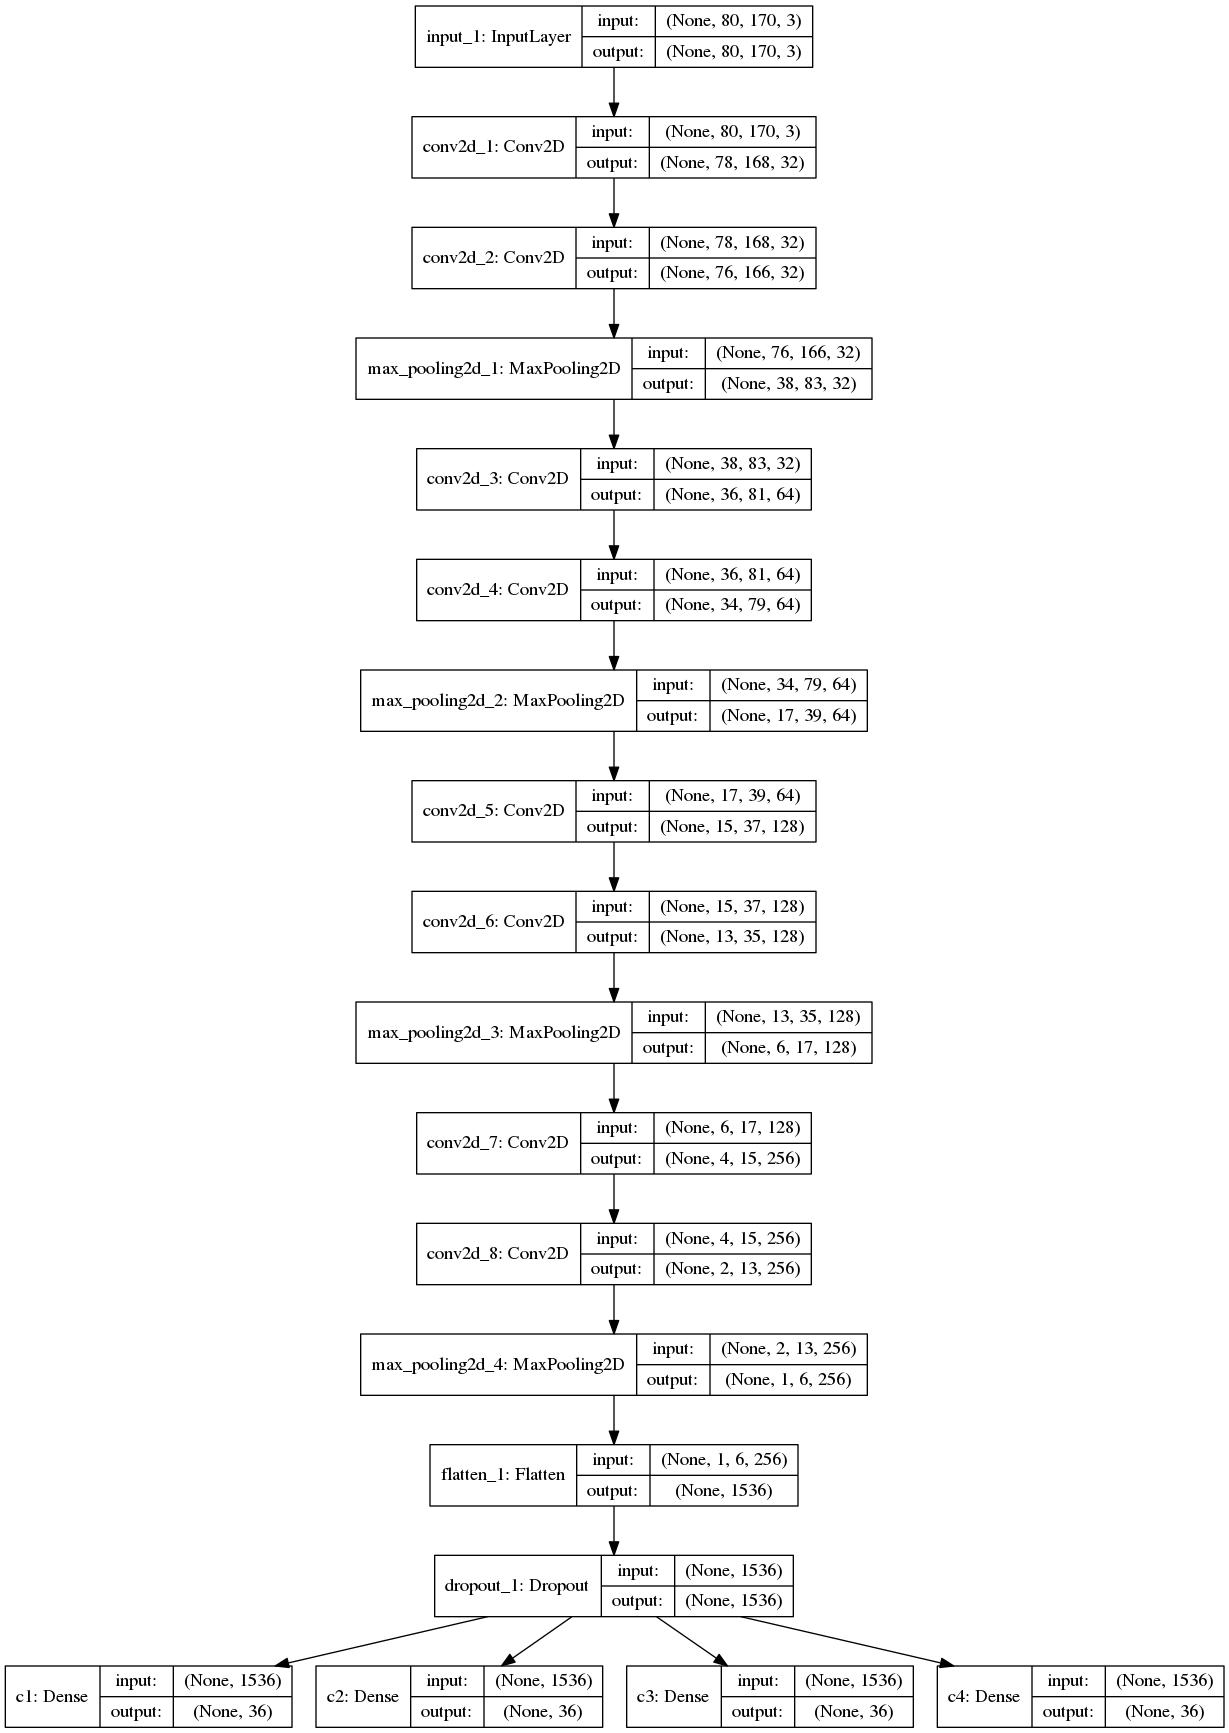

In [7]:
#from keras.utils.visualize_util import plot 
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

In [14]:
model.fit_generator(gen(), samples_per_epoch=51200, nb_epoch=5,
                    validation_data=gen(), nb_val_samples=1280)

Epoch 1/5


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=1280, validation_data=<generator..., epochs=5, steps_per_epoch=51200)`
  from ipykernel import kernelapp as app


ValueError: Error when checking model input: expected lstm_1_input to have 3 dimensions, but got array with shape (32, 80, 170, 3)

In [13]:
model.fit_generator(gen(), samples_per_epoch=51200, nb_epoch=5, 
                    nb_worker=2, pickle_safe=True, 
                    validation_data=gen(), nb_val_samples=1280)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=51200, workers=2, validation_steps=1280, epochs=5, pickle_safe=True)`
  app.launch_new_instance()


Epoch 1/5


ValueError: Error when checking model input: expected lstm_1_input to have 3 dimensions, but got array with shape (32, 80, 170, 3)

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
#这一行新加的，用于导入绘图包
from keras.utils.vis_utils import plot_model

import numpy as np
data_dim = 16
timesteps = 8
num_classes = 10

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(32, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# Generate dummy training data
x_train = np.random.random((1000, timesteps, data_dim))
y_train = np.random.random((1000, num_classes))

# Generate dummy validation data
x_val = np.random.random((100, timesteps, data_dim))
y_val = np.random.random((100, num_classes))

model.fit(x_train, y_train,
          batch_size=64, epochs=1,
          validation_data=(x_val, y_val))
#这一行新加的，用于绘图
plot_model(model, to_file='model1.png',show_shapes=True)

Train on 1000 samples, validate on 100 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 11.6310 - acc: 0.0970 - val_loss: 11.4407 - val_acc: 0.1500


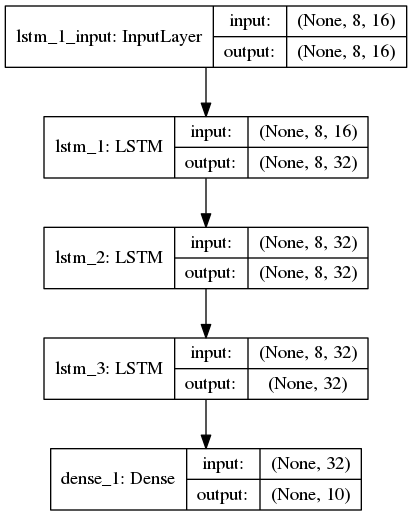

In [10]:
Image('model1.png')